# Multimode gmm
Created by: Daniel L. Marino (marinodl@vcu.edu)

Description: gaussian mixture model implementation on tensorflow, the objective is a multimode gaussian distribution. 

This file serves as a visual test for the gmm extension modules

In [1]:
import numpy as np
import collections
from time import time
import tensorflow as tf
from twodlearn.tf_lib.GMM import *
from twodlearn.tf_lib.datasets.generic import Datasets

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Create dataset

In [2]:

def gmm_sampling(mu, sigma, w, n_samples=1):
    # generates random vectors, sampled from a gausian mixture model
    #  
    #     - mu: 3d tensor containing the means for the gaussians.
    #           the "depth" dimention (3rd) is used to index the
    #           gaussians.    [ kernel_id, dim]
    #     - sigma: 3d tensor containing the covariance matrix of the
    #              gaussians. [ kernel_id, dim] for diagonal matrices
    #     - w: vector in form of a 3d tensor containing the weights
    #          for each one of the gaussians, they have to sum one. 
    #          [kernel_id]
    n_kernels = mu.shape[0]
    n_dim = mu.shape[1]
    
    # random sample the kernel from which the output samples are going
    # to be drawn
    kernel_id= np.argmax(np.random.multinomial(1, w, size=[n_samples]), axis=1 )
    
    out = np.zeros([n_samples, n_dim])
    for i in range(n_samples):
        out[i,:]= np.random.multivariate_normal(mu[kernel_id[i],:], np.diag(sigma[kernel_id[i],:])) # if diagonal
    
    return out;
    
    

In [3]:
n_samples = 5000000

n_kernels_r = 2
n_dim = 2
mu_r = np.array([[1, 1], [10, 10]])
sigma_r = np.array([[0.5, 0.5], [2, 2]])
w_r = [1/n_kernels_r]*n_kernels_r # has to sum to one

# random sample from reference distribution
aux_x = gmm_sampling(mu_r, sigma_r, w_r, n_samples);

# build the dataset
data = Datasets(aux_x)
data.normalize()
print('Data shape: ', data.train.x.shape)

# plot
#plt.plot(data.train.x[:,0], data.train.x[:,1], 'o')

Data shape:  (5000000, 2)


## 2. Model definition

In [4]:
#config = tf.ConfigProto( device_count = {'GPU': 0} )
#sess = tf.InteractiveSession(config = config)
sess = tf.InteractiveSession()

In [5]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
        tower_grads: List of lists of (gradient, variable) tuples. The outer list
        is over individual gradients. The inner list is over the gradient
        calculation for each tower.
    Returns:
        List of pairs of (gradient, variable) where the gradient has been averaged
        across all towers.
    """
    average_grads = []
    # 1. loop through each variable
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        # 2. loop through each tower
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)
            
        # Average over the 'tower' dimension.
        grad = tf.concat(0, grads)
        grad = tf.reduce_mean(grad, 0)
        
        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
        
    return average_grads

In [6]:
n_kernels = 2

with tf.device('/cpu:0'):
    gmm_model = GmmShallowModel( n_dim, n_kernels, diagonal= True, method='tdl')

# Create optimizer
optimizer = tf.train.AdamOptimizer(0.05)
    
# Create models for each gpu
tower_grads = []
train_models = []
with tf.device('/gpu:0'):
    train_model = gmm_model.setup(n_samples/2)
    train_models.append( train_model )
    
    grads = optimizer.compute_gradients(train_model.loss)
    
    tower_grads.append(grads)
    
with tf.device('/gpu:1'):
    train_model = gmm_model.setup(n_samples/2)
    train_models.append( train_model )
    
    grads = optimizer.compute_gradients(train_model.loss)
    
    tower_grads.append(grads)


# average gradients
grads = average_gradients(tower_grads)

# apply gradients
apply_gradient_op = optimizer.apply_gradients(grads);

In [7]:
print('mu shape:', train_model.mu.get_shape())
print('sigma shape:', train_model.sigma.get_shape())
print('w shape:', train_model.w.get_shape())

print('out shape:', train_model.out.get_shape())

print('loss shape:', train_model.loss.get_shape())


mu shape: (1, 2, 2)
sigma shape: (1, 2, 2)
w shape: (1, 2)
out shape: <unknown>
loss shape: <unknown>


## 3. Training

In [8]:
num_steps = 1000 #1000
n_logging = 100
n_test_logg = 10

tf.initialize_all_variables().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0

t0 = time()
for step in range(num_steps):  
    
    _, l1, l2 = sess.run([apply_gradient_op, train_models[0].loss, train_models[1].loss],
                         feed_dict={train_models[0].inputs : data.train.x[:(int)(n_samples/2)],
                                    train_models[1].inputs : data.train.x[(int)(n_samples/2):]
                                   })
    mean_loss += 0.5*(l1 + l2)
    
        
    if step%n_logging == 0:                
        print(step, ' | loss:', mean_loss/n_logging)
        mean_loss= 0

        
t1 = time()
print('function takes: ', (t1-t0))

Initialized
0  | loss: 70946.955
100  | loss: 2896638.12625
200  | loss: 1154178.595
300  | loss: 1153848.43875
400  | loss: 1153848.61375
500  | loss: 1153848.6825
600  | loss: 1153848.58125
700  | loss: 1153848.60125
800  | loss: 1153848.56375
900  | loss: 1153848.4975
function takes:  60.25836706161499


## 4. Plot

In [9]:
n_plot= [20, 20];

# model for testing
n_test= n_plot[0]*n_plot[1];
test_model = gmm_model.setup(n_test)


mu: [[[ 0.97103226  0.97099537]
  [-0.97007418 -0.97003728]]] sigma: [[[ 0.09286935  0.09299287]
  [ 0.02321834  0.023238  ]]] w: [[ 0.49956435  0.50043565]]
(20, 20)


<IPython.core.display.Javascript object>


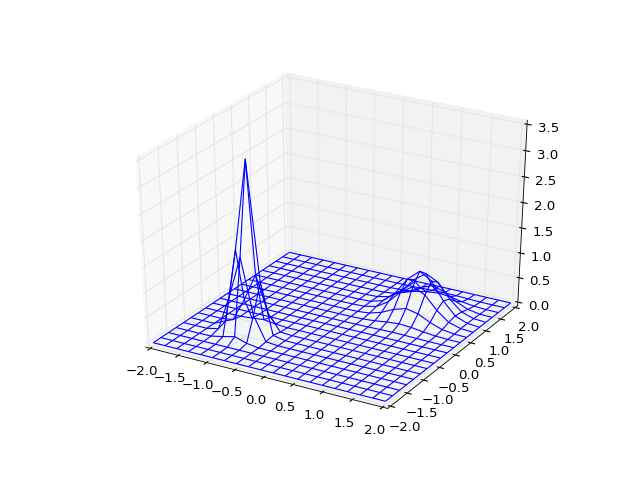

In [10]:

xv, yv = np.meshgrid(np.linspace(-2, 2, n_plot[1]), np.linspace(-2, 2, n_plot[0]))

x_plot = np.stack([xv.transpose(), yv.transpose()], 2)

x_plot = np.reshape(x_plot, [-1,2])

[p_plot, mu_out, sigma_out, w_out,] = sess.run([test_model.out, test_model.mu, test_model.sigma, test_model.w],
                                               feed_dict= {test_model.inputs : x_plot})
print('mu:', mu_out, 'sigma:', sigma_out, 'w:', w_out)


p_plot = np.reshape(p_plot, [n_plot[1], n_plot[0]])
print(p_plot.shape)

# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xv, yv, p_plot)

